In [82]:

import sys
from pathlib import Path

# Add parent directory (src/) to sys.path
sys.path.append(str(Path.cwd().parent))

from Data_Handler import get_data
import json
import os
import zipfile
from collections import Counter
from typing import Dict
import shutil
import sqlite3, json, os
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy


In [83]:
# loading in a specific board
data = get_data(board_name="12 x 12 with kickboard Square")
placements = data["placements"]
roles = data["roles"]

placements.describe(), roles.describe()



(            route_id     difficulty        hold_id      token_num  \
 count  452057.000000  452057.000000  452057.000000  452057.000000   
 mean   106045.795484    1242.255280     265.403715    1304.119410   
 std     65642.474089       4.485806     130.137169     130.992049   
 min         2.000000    1233.000000       3.000000    1073.000000   
 25%     47390.000000    1239.000000     176.000000    1199.000000   
 50%    105517.000000    1243.000000     277.000000    1287.000000   
 75%    162363.000000    1246.000000     363.000000    1389.000000   
 max    222622.000000    1253.000000     526.000000    1599.000000   
 
                    x              y         set_id  
 count  452057.000000  452057.000000  452057.000000  
 mean       72.420106      78.156463       5.165099  
 std        31.705649      43.410323       7.860596  
 min         4.000000       4.000000       1.000000  
 25%        48.000000      44.000000       1.000000  
 50%        72.000000      80.000000       1

In [84]:
# get the id of each hold in the 
holds_per_route = (
    placements.groupby("route_id")
    .agg(
        difficulty=("difficulty", "first"),
        hold_ids=("hold_id", list)
        )
    .reset_index()
)

# filer for routs with less than n holds
num_holds = 20
holds_per_route = holds_per_route[holds_per_route["hold_ids"].apply(len)< num_holds]

# subtracht difficulty offset
holds_per_route["difficulty"] = holds_per_route["difficulty"] - holds_per_route["difficulty"].min()
holds_per_route


,route_id,difficulty,hold_ids
0,2,6,"[42, 156, 94, 169, 115, 201, 84, 181, 68, 184,..."
1,5,7,"[432, 517, 349, 409, 297, 127, 241, 450, 228, ..."
2,10,8,"[395, 321, 430, 349, 410, 355, 19, 443, 336, 3..."
3,13,11,"[278, 324, 493, 262, 344, 373, 461, 481, 412, ..."
4,16,10,"[104, 223, 151, 261, 346, 372, 461, 353, 191, ..."
...,...,...,...
36474,222597,1,"[154, 210, 150, 227, 173, 287, 232, 255, 238, ..."
36475,222600,15,"[332, 436, 340, 378, 172, 259, 373, 175, 178, ..."
36476,222614,12,"[270, 382, 397, 289, 372, 176, 182, 134, 291]"
36477,222618,17,"[493, 341, 172, 236, 77, 108]"


In [85]:
mlb = MultiLabelBinarizer()

one_hot = pd.DataFrame(
    mlb.fit_transform(holds_per_route["hold_ids"]),
    columns=mlb.classes_,
    index=holds_per_route["route_id"]
).reset_index()

# Add back difficulty column
one_hot = one_hot.merge(
    holds_per_route[["route_id", "difficulty"]],
    on="route_id"
)

one_hot



,route_id,3,4,5,6,7,8,9,10,11,...,518,519,520,521,522,523,524,525,526,difficulty
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35005,222597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
35006,222600,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15
35007,222614,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
35008,222618,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17


In [86]:

# go up from src/ to project root, then into data/
project_root = Path.cwd().parent.parent   # if running from inside src/
data_dir = project_root / "data"

# make sure it exists
data_dir.mkdir(exist_ok=True)

# save one-hot CSV in data/
out_path = data_dir / "routes_onehot.csv"
one_hot.to_csv(out_path, index=False)

print(f"Saved to {out_path}")

Saved to /home/fillies/Documents/moon/kilter/data/routes_onehot.csv


In [87]:
from sklearn.preprocessing import OneHotEncoder
# Suppose 'difficulty' is the target
X = one_hot.drop(columns=["difficulty", "route_id"])
y = one_hot[["difficulty"]]




# also encode y in one hot for loss

enc = OneHotEncoder(sparse_output=False)
y = enc.fit_transform(y)

# Make a DataFrame for readability
y = pd.DataFrame(
    y,
    columns=[f"difficulty_{cls}" for cls in enc.categories_[0]],
    index=one_hot.index
)

print(y.shape)





(35010, 21)


# Starting of Moddel:

In [7]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 476]), torch.Size([64, 21]))

In [ ]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ShallowMLP, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(hidden_dim, num_classes)   # classification head
      )


    def forward(self, x):
        return self.model(x)

In [10]:

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def acc_fn(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    pred = torch.argmax(y_pred, dim=1)
    true = torch.argmax(y_true, dim=1)
    return (pred == true).float().mean()

In [53]:
class EarlyStopping:
    def __init__(self, patience=5, path="best_model.pt"):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [ ]:


def train_model(model, 
                train_loader, 
                test_loader, 
                loss_fn, 
                optimizer, 
                acc_fn, 
                device, 
                epochs=1000, 
                patience=5, 
                checkpoint_path="best_model.pt"):
    """
    Train a PyTorch model with early stopping.

    Args:
        model: torch.nn.Module
        train_loader, test_loader: DataLoaders
        loss_fn: loss function
        optimizer: optimizer
        acc_fn: accuracy function (expects preds, targets as indices)
        device: 'cuda' or 'cpu'
        epochs: max epochs
        patience: early stopping patience
        checkpoint_path: where to save best model

    Returns:
        model (loaded with best weights),
        history dict with train/test loss and accuracy
    """
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)

    all_train_loss, all_train_acc = [], []
    all_test_loss, all_test_acc = [], []

    train_time_start = timer()

    for epoch in tqdm(range(epochs)):
        # --- training ---
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            acc = acc_fn(torch.argmax(y_pred, dim=1),
                         torch.argmax(y, dim=1)).item()

            train_loss += loss.item()
            train_acc += acc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        all_train_loss.append(train_loss)
        all_train_acc.append(train_acc)

        # --- evaluation ---
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        with torch.inference_mode():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                test_pred = model(X_test)

                test_loss += loss_fn(test_pred, y_test).item()
                test_acc += acc_fn(torch.argmax(test_pred, dim=1),
                                   torch.argmax(y_test, dim=1)).item()

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        all_test_loss.append(test_loss)
        all_test_acc.append(test_acc)

        """if epoch % 10 == 0:
            print(f"\nEpoch {epoch:04d} | "
                  f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | "
                  f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")"""

        # --- early stopping ---
        if early_stopping(test_loss, model):
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch:04d} | "
                  f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | "
                  f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")
            break

    # reload best weights
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

    train_time_end = timer()
    print(f"Training complete in {train_time_end - train_time_start:.2f} sec")

    history = {
        "train_loss": all_train_loss,
        "train_acc": all_train_acc,
        "test_loss": all_test_loss,
        "test_acc": all_test_acc
    }

    return model, history


In [77]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and test loss/accuracy from history dict.

    Args:
        history: dict with keys 'train_loss', 'test_loss', 
                 'train_acc', 'test_acc'
    """
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # ---- Loss plot ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.legend()

    # ---- Accuracy plot ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
shallowMLP = ShallowMLP(input_dim=X_test.shape[1],
                        hidden_dim=32,
                        num_classes= y_test.shape[1]
                        ).to(device)


loss_fn = torch.nn.BCEWithLogitsLoss()
acc_fn = MulticlassAccuracy(num_classes=21).to(device)
optimizer = optim.Adam(shallowMLP.parameters(), lr=1e-3, weight_decay=1e-5 )



In [80]:
model, history = train_model(
    shallowMLP,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    acc_fn,
    device,
    epochs=1000,
    patience=10
)

config = {
    "epochs": 1000,
    "patience": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "checkpoint_path": "best_model.pt",
}




  4%|▍         | 44/1000 [02:29<54:13,  3.40s/it]  

Early stopping at epoch 44

Epoch 0044 | Train loss: 0.14669 | Train acc: 0.18482 | Test loss: 0.15109 | Test acc: 0.16082
Training complete in 149.75 sec


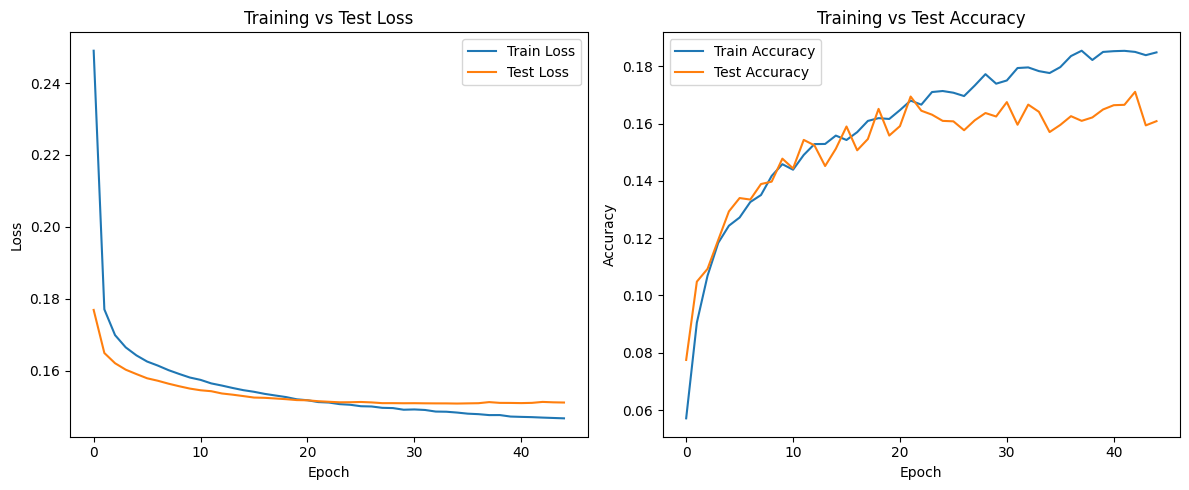

In [81]:
plot_training_history(history)